In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import sys
from read_alf import Alf
import warnings
warnings.filterwarnings("ignore")

In [2]:
split_num =2 

path = '../data/alf/'
sga_mass = fits.getdata('../data/sga_mass_new.fits', 1)
split = fits.open('../data/sample_split_outliers_total.fits')
r_median = fits.open('../data/rmax_median_re2.fits')
rnames = ['rin_median(kpc)', 'rmid_median(kpc)', 'rout_median(kpc)']

split_type = ['mtot_v_m10kpc', 'sigma_v_mtot', 'm20kpc_v_sigmacen', 'm10kpc_v_m20kpc_control']
label_names = ['high', 'low']
radius_name = ['in', 'mid', 'out']
labels = ['High', 'Low']

normalize = mcolors.Normalize(vmin=-1.3, vmax=0.3)
colormap = mpl.cm.PRGn
color_low = colormap(normalize(-1))
color_high = colormap(normalize(0))
colors = [color_high, color_low]
edgecolors = ['xkcd:forest', 'xkcd:blue violet']
shapes = ['o', 'd']
sample_labels = [r'$\mathrm{Extended}$', r'$\mathrm{Compact}$']

ele_abundances = ['Mg']
params = ['Mg']
titles = ['zH', 'Mg', 'Mg/Fe']
titles = np.array(titles)
titles0 = np.array([r'$\mathbf{[Fe/H]}$', r'$\mathbf{[Mg/H]}$', r'$\mathbf{[Mg/Fe]}$'])

keywords = ['zH', 'Mg', 'Mg/Fe', 'FeH', 'zH2', 'r_re', 'r_kpc']


data = {}
err = {}
sigdata = {}

for i in range(2):
    for name in keywords:
        data[name] = [[[], [], []], [[], [], []]]
        err[name] = [[[], [], []], [[], [], []]]
        sigdata[name] = [[], [], []]

for j in range(3):
    for i in range(2):
        myalf = Alf(
            path + split_type[split_num] + '/' + label_names[i] + '_' + split_type[split_num] + '_median_'
            + radius_name[j])
        myalf.get_total_met()
        myalf.abundance_correct()
        data['FeH'][i][j].append(myalf.results['FeH'][5])
        err['FeH'][i][j].append(myalf.results['FeH'][2])

        data['zH'][i][j].append(myalf.tmet['cl50'])
        err['zH'][i][j].append(myalf.tmet['std'])
        for name in params:
            data[name][i][j].append(myalf.results[name][5]+myalf.results['zH'][5])
            err[name][i][j].append(np.sqrt(myalf.results[name][2]**2+myalf.results['zH'][2]**2))

        for name in ele_abundances:
            data[name + '/Fe'][i][j].append(data[name][i][j][-1]-data['zH'][i][j][-1])
            err[name + '/Fe'][i][j].append(err[name][i][j][-1]-err['zH'][i][j][-1])

        data['zH2'][i][j].append(data['Mg/Fe'][i][j][-1] * 0.94 + data['zH'][i][j][-1])
        err['zH2'][i][j].append(err['Mg/Fe'][i][j][-1] * 0.94 + err['zH'][i][j][-1])


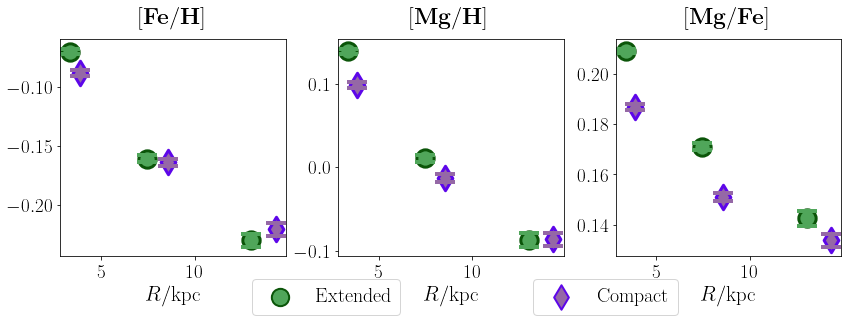

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Charter",
    "xtick.labelsize": 19,
    "ytick.labelsize": 19,
    "axes.labelsize": 21,
    "axes.labelweight": "bold"
    })
fig, ax = plt.subplots(1, 3, figsize=(14, 4), clear=True)
for idx_cal, name in enumerate(titles):
    func = []
    ax[idx_cal].set_title(titles0[idx_cal], x=.5, y=1.04, fontsize=23)
    ax[idx_cal].set_xlabel(r'$R\mathrm{/kpc}$')
    xmin, xmax = 10, 10
    for i in range(2):
        mask = split[1].data[split_type[split_num]] % 2 == i
        ifus, idx, _ = np.intersect1d(r_median[1].data['plateifu'], split[1].data['plateifu'][mask],
                                      return_indices=True)
        _, idx_re, idx0 = np.intersect1d(sga_mass['plateifu'], ifus, return_indices=True)
        re = sga_mass['Re_kpc'][idx_re]
        dx_tmp,dy_tmp=[],[]
        for j in range(3):
            r_tmp = np.nanmedian(r_median[1].data[rnames[j]][idx])
            re_tmp = np.nanmedian(r_median[1].data[rnames[j]][idx] / re)
            data['r_kpc'][i][j].append(r_tmp)
            data['r_re'][i][j].append(re_tmp)

            idx_r = np.where(r_median[1].data['plateifu'] == '10513-12701')[0][0]
            if r_tmp < xmin:
                xmin = np.copy(r_tmp)
            if r_tmp > xmax:
                xmax = np.copy(r_tmp)

            ax[idx_cal].errorbar([r_tmp], [data[name][i][j]], yerr=[err[name][i][j]],
                                 ecolor=colors[i], linewidth=3, capsize=10, capthick=4, linestyle=None,
                                 alpha=1)
            ax[idx_cal].scatter([r_tmp], [data[name][i][j]], s=300,
                                edgecolors=edgecolors[i], facecolors=colors[i], linewidths=3,
                                marker=shapes[i],
                                alpha=1)
            dx_tmp.append(r_tmp)
            dy_tmp.append(data[name][i][j][0])
        func_tmp = np.polyfit(dx_tmp, dy_tmp, 1)
        func.append(np.poly1d(func_tmp))

ax[0].scatter([], [], s=300, marker=shapes[0], facecolor=colors[0], edgecolor=edgecolors[0], label=sample_labels[0],
              lw=2)
ax[1].scatter([], [], s=300, marker=shapes[1], facecolor=colors[1], edgecolor=edgecolors[1], label=sample_labels[1],
              lw=2)
fig.subplots_adjust(wspace=0.23)

ax[0].legend(fontsize=20, bbox_to_anchor=(1.55, -.06))
ax[1].legend(fontsize=20, bbox_to_anchor=(1.55, -.06))